# Влияние различных факторов на результаты выпускных экзаменов
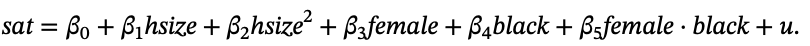


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# set pd/np parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True)

#  plot imports
import matplotlib.pyplot as plt
import seaborn as sns

# set plt/sns parameters
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (15, 8)
sns.set_style("whitegrid")

### Загрузка данных

In [7]:
data = pd.read_csv('GPA2.txt', sep="\t")
data

,sat,tothrs,colgpa,athlete,verbmath,hsize,hsrank,hsperc,female,white,black,hsizesq,Unnamed: 12
0,920,43,2.04,1,0.48,0.10,4,40.00,1,0,0,0.01,NaN
1,1170,18,4.00,0,0.83,9.40,191,20.32,0,1,0,88.36,NaN
2,810,14,1.78,1,0.88,1.19,42,35.29,0,1,0,1.42,NaN
3,940,40,2.42,0,0.81,5.71,252,44.13,0,1,0,32.60,NaN
4,1180,18,2.61,0,0.74,2.14,86,40.19,0,1,0,4.58,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,990,49,2.24,0,1.02,2.33,89,38.20,1,1,0,5.43,NaN
4133,900,50,2.46,0,0.96,0.10,2,20.00,1,1,0,0.01,NaN
4134,1340,62,4.00,0,0.94,0.45,1,2.22,0,1,0,0.20,NaN
4135,980,12,2.83,0,0.69,0.35,23,65.71,1,1,0,0.12,NaN


### Описательная статистика переменных

In [10]:
summary_2 = data[['sat', 'hsize', 'female', 'black']].describe().transpose().round(2)
summary_2

,count,mean,std,min,25%,50%,75%,max
sat,4137.00,1030.33,139.40,470.00,940.00,1030.00,1120.00,1540.00
hsize,4137.00,2.80,1.74,0.03,1.65,2.51,3.68,9.40
female,4137.00,0.45,0.50,0.00,0.00,0.00,1.00,1.00
black,4137.00,0.06,0.23,0.00,0.00,0.00,0.00,1.00


#### Создание файла-эксель с описательной статистикой

In [19]:
from openpyxl import Workbook
from openpyxl.styles import Font, Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows

def calculate_and_save_summary(df, variables, filename='summary_statistics.xlsx', title='Summary Statistics'):
    
    # df (DataFrame): исходный DataFrame.
    # variables (list): список переменных для анализа.
    # filename (str): имя файла Excel для сохранения результата.
    # title (str): заголовок таблицы в Excel.

    # расчёт суммарной статистики
    summary_df = df[variables].describe().transpose().round(2)
    
    # словарь для перевода названий переменных
    column_names = {
        'sat': 'комбинированный результат выпускных тестов',
        'hsize': 'суммарный размер выпускных классов в школе (в сотнях человек)',
        'female': 'пол',
        'black': 'раса'
    }
    renamed_df = summary_df.rename(index=column_names)

    # создание нового Excel-файла
    wb = Workbook()
    ws = wb.active
    ws.title = 'Statistics'

    # заголовок
    ws.append([title])
    ws["A1"].font = Font(bold=True, size=14)
    ws.append([]) 

    # добавление строк из DataFrame в Excel-лист
    for r_idx, row in enumerate(dataframe_to_rows(renamed_df, index=True, header=True), start=3):
        ws.append(row)
        
        if r_idx > 2: 
            for cell in ws[r_idx]:
                cell.border = Border(
                    left=Side(style='thin'),
                    right=Side(style='thin'),
                    top=Side(style='thin'),
                    bottom=Side(style='thin')
                )

    ws.delete_rows(4)

    # сохранение файла
    wb.save(filename)
    print(f"Таблица сохранена в файл: {filename}")


calculate_and_save_summary(data, ['sat', 'hsize', 'female', 'black'], 'summary(2).xlsx', 'Описательная статистика для sat, hsize, female, black')

Таблица сохранена в файл: summary(2).xlsx


### Оценка модели

In [17]:
X = data[['hsize', 'hsizesq', 'female', 'black']].copy()
X.loc[:, 'female:black'] = data['female'] * data['black']   # взаимодействие переменных female и black
X = sm.add_constant(X)  # добавляем константу

# объясняемая переменная y
y = data['sat']

model = sm.OLS(y, X).fit(cov_type='HC0') # гетероскедастичные ошибки

print (model.summary())

                            OLS Regression Results                            
Dep. Variable:                    sat   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     74.63
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           4.51e-75
Time:                        21:26:06   Log-Likelihood:                -26110.
No. Observations:                4137   AIC:                         5.223e+04
Df Residuals:                    4131   BIC:                         5.227e+04
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1028.0972      6.355    161.777   

In [21]:
from stargazer.stargazer import Stargazer

def generate_stargazer_html(models, title, output_file, dependent_var_name ='Зависимая переменная'):

    # models: Список регрессионных моделей (экземпляров statsmodels.api.OLS).
    # model_names: Словарь перевода названий переменных на русский.
    # title (str): Заголовок таблицы.
    # output_file (str): Имя HTML-файла для сохранения.
    
    # cоздаем объект Stargazer для всех моделей
    stargazer = Stargazer(models)
    stargazer.title(title)
    
    # заменяем названия переменных на русские
    model_names = {
        'const': 'константа',
        'sat': 'результат выпускных тестов',
        'hsize': 'суммарный размер выпускных классов (в сотнях человек)',
        'hsizesq': 'суммарный размер выпускных классов в квадрате',
        'female': 'пол',
        'black': 'раса',
        'female:black': 'пол и раса',
        'athlete': '1, если спортсмен',
        'hsrank': 'рейтинг в выпускном классе',
        'tothrs': 'суммарные часы посещения'
        
    }
    stargazer.rename_covariates(model_names)
    
    #удаляем ненужные метрики из таблицы
    stargazer.covariate_order = list(model_names.keys())  # упорядочиваем переменные
    stargazer.show_residual_std_err = False
    stargazer.show_f_statistic = False
    stargazer.show_adj_r2 = False

    # генерация HTML
    html = stargazer.render_html()
    html = html.replace('Dependent variable: sat', dependent_var_name)  # переименовываем
    html = html.replace('Observations', 'Число наблюдений')
    html = html.replace('Note', 'Замечание')   

    # генерация полного HTML-документа
    stargazer_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
    <meta charset="UTF-8">
    <title>Результаты регрессии</title>
    </head>
    <body>
    {html}
    </body>
    </html>
    """

    # сохранение в файл
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write(stargazer_html)
    
    print(f"Результаты регрессии сохранены в файл {output_file}.")

generate_stargazer_html(models=[model],
                        title='Модель',
                        output_file='regression_results.html',
                        dependent_var_name='суммарный результат выпускных тестов')

Результаты регрессии сохранены в файл regression_results.html.


### Статистическая значимость

In [24]:
significance = model.pvalues < 0.05
print("Коэффициенты, значимые на уровне 5%:")
print (model.params[significance])

Коэффициенты, значимые на уровне 5%:
const          1028.10
hsize            19.30
hsizesq          -2.19
female          -45.09
black          -169.81
female:black     62.31
dtype: float64


### Зависимость результатов тестов от переменной hsize

In [27]:
# Тест Вальда
wald_test = model.wald_test(['hsize = 0', 'hsizesq = 0'], scalar = True)
print(wald_test)

<Wald test (chi2): statistic=29.675299442016986, p-value=3.598243932597043e-07, df_denom=2>


### При каком размере классов достигается наилучший средний результат тестирования?

In [30]:
from scipy.stats import norm

# Коэффициенты модели
b3 = model.params['hsize']     # Линейный коэффициент
b4 = model.params['hsizesq']   # Квадратичный коэффициент

# Матрица ковариации коэффициентов
cov_matrix = model.cov_params()
var_b3 = cov_matrix.loc['hsize', 'hsize']         # Дисперсия b3
var_b4 = cov_matrix.loc['hsizesq', 'hsizesq']    # Дисперсия b4
cov_b3_b4 = cov_matrix.loc['hsize', 'hsizesq']   # Ковариация b3 и b4

# Точка максимума
hsize_star = -b3 / (2 * b4)

# Производные
partial_b3 = -1 / (2 * b4)
partial_b4 = b3 / (2 * b4**2)

# Стандартная ошибка
se_hsize_star = np.sqrt(
    (partial_b3**2) * var_b3 +
    (partial_b4**2) * var_b4 +
    2 * partial_b3 * partial_b4 * cov_b3_b4
)

print(f"Оптимальный размер класса: {hsize_star:.2f} (в сотнях человек)")

Оптимальный размер класса: 4.40 (в сотнях человек)


### Постройте 95%-ный доверительный интервал для точки максимума

In [34]:
z_critical = norm.ppf(0.975)
ci_low = hsize_star - z_critical * se_hsize_star
ci_high = hsize_star + z_critical * se_hsize_star

print(f"95%-й доверительный интервал: [{ci_low:.2f}, {ci_high:.2f}]")

95%-й доверительный интервал: [3.71, 5.08]


### Доп. исследование зависимости от рейтинга

In [39]:
X1 = data[['colgpa', 'hsize', 'hsizesq', 'hsrank', 'female', 'black']].copy()

X1.loc[:, 'female:black'] = data['female'] * data['black']
X1 = sm.add_constant(X1)

y1 = data['sat']

model_1 = sm.OLS(y1, X1).fit(cov_type='HC0')

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    sat   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     191.4
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          1.70e-246
Time:                        21:37:57   Log-Likelihood:                -25667.
No. Observations:                4137   AIC:                         5.135e+04
Df Residuals:                    4129   BIC:                         5.140e+04
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          848.2310     10.436     81.281   

### Доп. исследование зависимости от бинарной переменной спортсмен / не спортсмен

In [42]:
X2 = data[['colgpa', 'hsize', 'hsizesq', 'female', 'black', 'athlete']].copy()

X2 = sm.add_constant(X2)

y2 = data['sat']

model_2 = sm.OLS(y2, X2).fit(cov_type='HC0')

print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    sat   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     214.8
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          3.11e-239
Time:                        21:39:08   Log-Likelihood:                -25671.
No. Observations:                4137   AIC:                         5.136e+04
Df Residuals:                    4130   BIC:                         5.140e+04
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        818.3162      9.763     83.819      0.0

### Доп. исследование зависимости от посещения

In [46]:
X3 = data[['colgpa', 'hsize', 'hsizesq','female', 'black', 'tothrs']].copy()

X3.loc[:, 'female:black'] = data['female'] * data['black']

X3 = sm.add_constant(X3)

y3 = data['sat']

model_3 = sm.OLS(y3, X3).fit(cov_type='HC0')

print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    sat   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     170.1
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          9.69e-222
Time:                        21:39:34   Log-Likelihood:                -25716.
No. Observations:                4137   AIC:                         5.145e+04
Df Residuals:                    4129   BIC:                         5.150e+04
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          815.5148     10.044     81.196   

### Генерация сводной таблицы моделей

In [35]:
def generate_custom_html_table(models, variables, title, output_file):
   
    def extract_model_results_with_significance(model, variables):
        # Извлекает коэффициенты, их стандартные ошибки и значимость из модели.
        
        coef = model.params
        std_err = model.bse
        p_values = model.pvalues
        results = []
        for var in variables:
            if var in coef.index:
                stars = ""
                if p_values[var] < 0.01:
                    stars = "***"
                elif p_values[var] < 0.05:
                    stars = "**"
                elif p_values[var] < 0.1:
                    stars = "*"
                results.append(f"{coef[var]:.3f}{stars} ({std_err[var]:.3f})")
            else:
                results.append("–")  # Если переменной нет в модели
        return results

    # Заголовок таблицы
    table_header = """
    <table style="border-collapse: collapse; width: 100%; text-align: center;">
        <tr style="border: 1px solid black; background-color: #f2f2f2;">
            <th>Переменные</th>
    """
    for i in range(len(models)):
        table_header += f"<th>Модель {i + 1}</th>"
    table_header += "</tr>"

    # Тело таблицы
    rows = ""
    for var_index, variable_name in enumerate([
        'const', 'hsize', 'hsizesq', 'female', 'black', 'female:black', 'athlete', 'hsrank', 'tothrs'
    ]):
        rows += "<tr>"
        rows += f"<td style='border: 1px solid black; padding: 5px;'>{variable_name}</td>"
        for model_index, model in enumerate(models):
            results = extract_model_results_with_significance(model, variables)
            rows += f"<td style='border: 1px solid black; padding: 5px;'>{results[var_index]}</td>"
        rows += "</tr>"

    # Добавление строк для числа наблюдений и R²/R²adj
    rows += "<tr>"
    rows += "<td style='border: 1px solid black; padding: 5px;'>Число наблюдений</td>"
    for model in models:
        rows += f"<td style='border: 1px solid black; padding: 5px;'>{model.nobs}</td>"
    rows += "</tr>"

    rows += "<tr>"
    rows += "<td style='border: 1px solid black; padding: 5px;'>R²</td>"
    for model in models:
        rows += f"<td style='border: 1px solid black; padding: 5px;'>{model.rsquared:.3f}</td>"
    rows += "</tr>"

    rows += "<tr>"
    rows += "<td style='border: 1px solid black; padding: 5px;'>R²adj</td>"
    for model in models:
        rows += f"<td style='border: 1px solid black; padding: 5px;'>{model.rsquared_adj:.3f}</td>"
    rows += "</tr>"

    # Закрытие таблицы
    table_footer = "</table>"

    # Генерация полного HTML-документа
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
    <meta charset="UTF-8">
    <title>{title}</title>
    <style>
        table {{ border-collapse: collapse; width: 100%; text-align: center; }}
        th, td {{ border: 1px solid black; padding: 5px; }}
        th {{ background-color: #f2f2f2; }}
    </style>
    </head>
    <body>
    <h1>{title}</h1>
    {table_header}
    {rows}
    {table_footer}
    </body>
    </html>
    """

    # Сохранение в файл
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write(html)
    
    print(f"Результаты сохранены в файл {output_file}.")

# Переменные модели
variables = ['const', 'hsize', 'hsizesq', 'female', 'black', 'female:black', 'athlete', 'hsrank', 'tothrs']

# Вызов функции для генерации HTML
generate_custom_html_table(
    models=[model, model_1, model_2, model_3],  # Модели, которые должны быть включены в таблицу
    variables=variables,
    title="Результаты регрессий",
    output_file="regression_results_all.html"
)

Результаты сохранены в файл regression_results_all.html.
